Import Inception V3 model

In [0]:

from tensorflow.keras.applications.inception_v3 import InceptionV3


We will be using all the layers in the model except the last fully connected layer as it is specific to 'imagenet'

In [2]:
pre_trained_model = InceptionV3(input_shape= (250,400,3), include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


Setting all the layers as non trainable

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable=False


We use categorical_crossentropy as the loss metric as we have 10 target classes. Our optimizer is Adam with a learning rate of 0.0001.

In [0]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import Model
x = pre_trained_model.output

x = layers.Flatten()(x)
x = layers.Dense(1024,activation = 'relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(10, activation='softmax')(x)
model = Model(pre_trained_model.input,x)
model.compile(optimizer = Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

**Rescaling Images Using ImageDataGenerator**

Using ImageDataGenerator class, we will read images from the source folder and feed them to the network. One generator for training and other for validating. Normalization helps in processing of data in neural nets hance we will process the images by normalizing the pixel values to be [0,1] After rescaling the images, and using Image Augmentation, we flow them in batches of 20 using train_datagen and test_datagen.


We also perform **image augmentation** where we change the images a bit by rotating them, squashing them, etc.





In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


We have 6980 training images with 10 classes

In [0]:
train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/train2', batch_size = 20, class_mode='categorical', target_size=(299,299))

Found 6980 images belonging to 10 classes.


In [0]:
print(train_generator.dtype)

float32


We have 1740 testing images with 10 classes

In [0]:
validation_generator = test_datagen.flow_from_directory('/content/drive/My Drive/test2', batch_size = 20, class_mode='categorical', target_size=(299,299))

Found 1740 images belonging to 10 classes.


In [0]:
print(validation_generator.dtype)

float32


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=349,  
      epochs=100,
      validation_data=validation_generator,
      validation_steps=87,  
      verbose=1)

Epoch 1/100
349/349 [==============================] - 143s 411ms/step - loss: 1.4295 - accuracy: 0.6234 - val_loss: 0.6425 - val_accuracy: 0.7845
Epoch 2/100
349/349 [==============================] - 147s 420ms/step - loss: 0.7728 - accuracy: 0.7415 - val_loss: 0.5716 - val_accuracy: 0.7994
Epoch 3/100
349/349 [==============================] - 148s 425ms/step - loss: 0.6844 - accuracy: 0.7686 - val_loss: 0.4972 - val_accuracy: 0.8310
Epoch 4/100
349/349 [==============================] - 150s 430ms/step - loss: 0.5884 - accuracy: 0.8059 - val_loss: 0.4610 - val_accuracy: 0.8471
Epoch 5/100
349/349 [==============================] - 150s 430ms/step - loss: 0.5542 - accuracy: 0.8146 - val_loss: 0.4809 - val_accuracy: 0.8316
Epoch 6/100
349/349 [==============================] - 152s 435ms/step - loss: 0.5209 - accuracy: 0.8238 - val_loss: 0.4044 - val_accuracy: 0.8569
Epoch 7/100
349/349 [==============================] - 151s 434ms/step - loss: 0.4649 - accuracy: 0.8427 - val_loss: 0

In [0]:
# Evaluating the model on the training and testing set
score = model.evaluate(train_generator, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(validation_generator, verbose=1)
print("Testing Accuracy: ", score[1])

  35222/Unknown - 13379s 380ms/step - loss: 0.0372 - accuracy: 0.9872

**Define a Callback class that stops training once accuracy reaches 95%**

In [0]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.95):
      print("\nReached 95.00% accuracy so cancelling training!")
      self.model.stop_training = True

**Using the layers including and above mixed 7**, here we do not use all the layers in the pre-trained model

In [5]:
last_layer = pre_trained_model.get_layer('mixed7') #Only use layers including and above 'mixed7'
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 13, 23, 768)


In [0]:

#last_layer = pre_trained_model.get_layer('mixed7')
#print('last layer output shape: ', last_layer.output_shape)
#last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)                  
# Add a final softmax layer for classification
x = layers.Dense  (10, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# The validation data will not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/train2',
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (250, 400))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( '/content/drive/My Drive/test2',
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (250, 400))

Found 6980 images belonging to 10 classes.
Found 1740 images belonging to 10 classes.


To calculate steps_per_epoch  we used Toal training images // batch_size

To calculate validation_steps  we used Toal test images // batch_size



In [10]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 349,
            epochs = 100,
            validation_steps = 87,
            verbose = 1,
            callbacks=[callbacks])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
349/349 [==============================] - 9644s 28s/step - loss: 1.1419 - acc: 0.6160 - val_loss: 0.7738 - val_acc: 0.7517
Epoch 2/100
349/349 [==============================] - 282s 807ms/step - loss: 0.6159 - acc: 0.7983 - val_loss: 0.4381 - val_acc: 0.8500
Epoch 3/100
349/349 [==============================] - 281s 806ms/step - loss: 0.5107 - acc: 0.8332 - val_loss: 0.5779 - val_acc: 0.8092
Epoch 4/100
349/349 [==============================] - 281s 804ms/step - loss: 0.4009 - acc: 0.8668 - val_loss: 0.4141 - val_acc: 0.8799
Epoch 5/100
349/349 [==============================] - 281s 804ms/step - loss: 0.3497 - acc: 0.8812 - val_loss: 0.3762 - val_acc: 0.8753
Epoch 6/100
349/349 [==============================] - 282s 807ms/step - loss: 0.3158 - acc: 0.8976 - val_loss: 0.3292 - val_acc: 0.8920
Epoch 7/100
349/349 [==============================] - 282s 809ms/step - loss: 0.3005 - acc: 0.8970 - v

**Plot accuracy and Loss**

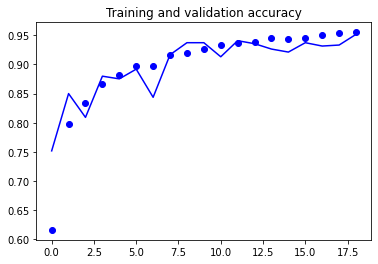

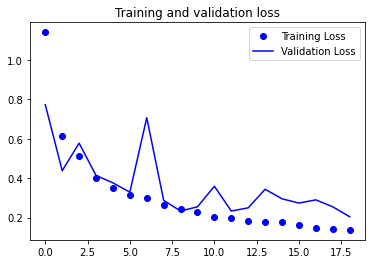

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Calculating Testing Accuracy**

In [26]:
score = model.evaluate_generator(validation_generator, 1740/20, verbose=1)

87/87 [==============================] - 15s 176ms/step - loss: 0.2233 - acc: 0.9500
